# Importing Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import tensorflow as tf
import tensorflow.keras.layers as tfl

# Displaying images and maskes

In [19]:
def display_images(data, no_img_mask):
    
    # Load the images from the files
    images = glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraRGB/*.png')[:no_img_mask]
    masks = glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraSeg/*.png')[:no_img_mask]

    for i in range(len(images)):
        images[i] = cv2.imread(images[i])
        masks[i] = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)



    fig, axes = plt.subplots(no_img_mask, 2)

    for i in range(len(images)):
        axes[i][0].imshow(images[i])
        axes[i][1].imshow(masks[i])

    # Show the plot
    plt.show()

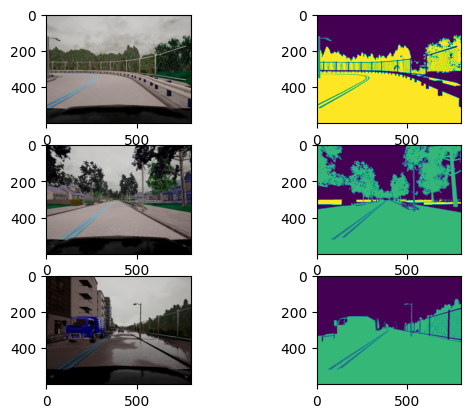

In [20]:
display_images('dataA', 3)

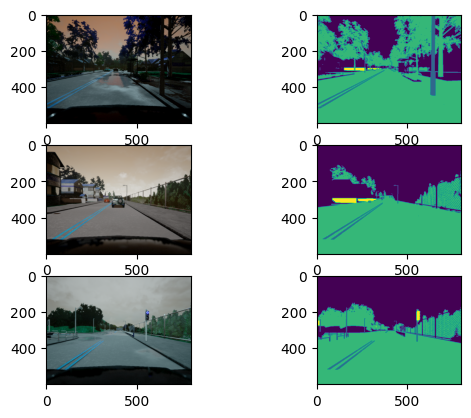

In [21]:
display_images('dataB', 3)

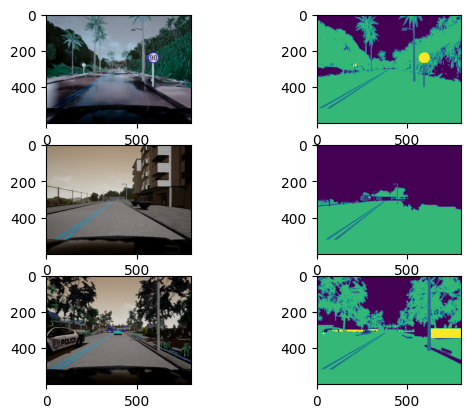

In [22]:
display_images('dataC', 3)

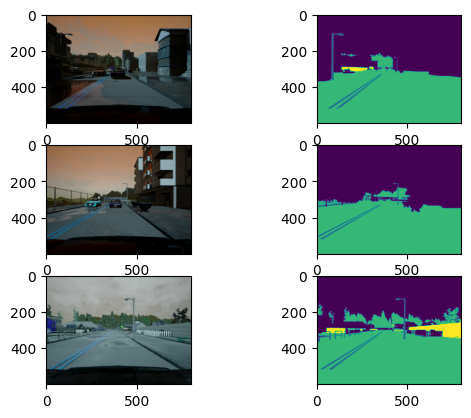

In [23]:
display_images('dataD', 3)

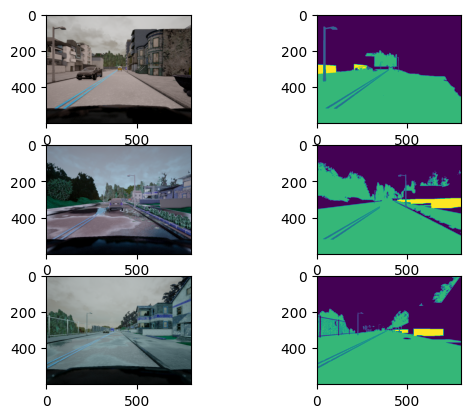

In [24]:
display_images('dataE', 3)

# Storing images and mask paths

In [25]:
images_list = []
masks_list = []
def store_imgs_masks(data):
    images_list.append(glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraRGB/*.png'))
    masks_list.append(glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraSeg/*.png'))

In [26]:
store_imgs_masks('dataA')
store_imgs_masks('dataB')
store_imgs_masks('dataC')
store_imgs_masks('dataD')
store_imgs_masks('dataE')

## Viewing the list just created

In [27]:
print(images_list[0][:5],'\n')
print(masks_list[0][:5])

['/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F2-90.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_161.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_090.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_040.png'] 

['/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F2-90.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_161.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_090.png', '/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_040.png']


# Transforming the list of images and masks into one list for images and one for masks

In [28]:
def get_one_list(list_of_lists):
    
    one_list = []

    for sublist in list_of_lists:
        one_list.extend(sublist)
    return one_list

In [29]:
images_list = get_one_list(images_list)
masks_list = get_one_list(masks_list)

In [30]:
print(images_list[50], '\n')
print(masks_list[50])

/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F62-70.png 

/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F62-70.png


# Transforming the list to tensor

In [31]:
image_list_ds = tf.data.Dataset.list_files(images_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(masks_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_010.png'>)


# Combining images and masks into pairs

In [32]:
image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(masks_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png', shape=(), dtype=string)


# Preprocessing of images and masks

In [33]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

# Building UNet V2 architecture

## Encoder (Downsampling Block)

In [34]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = tfl.Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = tfl.MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [35]:
# def conv_block_2(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.ReLU()(layer)
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(layer)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.ReLU()(layer)
    
#     if dropout_prob > 0:
#         layer = tfl.Dropout(dropout_prob)(layer)
        
#     if max_pooling:
#         next_layer = tfl.MaxPooling2D(pool_size=(2,2))(layer)
        
#     else:
#         next_layer = layer
        
#     skip_connection = layer
    
#     return next_layer, skip_connection

In [36]:
# def conv_block_3(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.LeakyReLU()(layer)
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(layer)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.LeakyReLU()(layer)
    
#     if dropout_prob > 0:
#         layer = tfl.Dropout(dropout_prob)(layer)
        
#     if max_pooling:
#         next_layer = tfl.MaxPooling2D(pool_size=(2,2))(layer)
        
#     else:
#         next_layer = layer
        
#     skip_connection = layer
    
#     return next_layer, skip_connection

## Decoder (Upsampling Block)

In [37]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = tfl.Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(expansive_input)
    merge = tfl.concatenate([up, contractive_input], axis=3)
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

In [38]:
# def upsampling_block_2(expansive_input, contractive_input, n_filters=32):
#     up = tfl.Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(expansive_input)
#     merge = tfl.concatenate([up, contractive_input], axis=3)
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(merge)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.ReLU()(layer)
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(layer)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.ReLU()(layer)
#     return layer

In [39]:
# def upsampling_block_3(expansive_input, contractive_input, n_filters=32):
#     up = tfl.Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(expansive_input)
#     merge = tfl.concatenate([up, contractive_input], axis=3)
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(merge)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.LeakyReLU()(layer)
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(layer)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.LeakyReLU()(layer)
#     return layer

# Building the model

In [40]:
def unet_model(input_size=(96,128,3), n_filters=32, n_classes = 13):
    inputs = tfl.Input(input_size)
    
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)
    
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
    
    conv9 = tfl.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = tfl.Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

In [41]:
# def unet_model2(input_size=(96,128,3), n_filters=32, n_classes = 13):
#     inputs = tfl.Input(input_size)
    
#     cblock1 = conv_block_2(inputs, n_filters)
    
#     cblock2 = conv_block_2(cblock1[0], n_filters * 2)
#     cblock3 = conv_block_2(cblock2[0], n_filters * 4)
#     cblock4 = conv_block_2(cblock3[0], n_filters * 8, dropout_prob=0.3)
    
#     cblock5 = conv_block_2(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)
    
#     ublock6 = upsampling_block_2(cblock5[0], cblock4[1], n_filters * 8)
#     ublock7 = upsampling_block_2(ublock6, cblock3[1], n_filters * 4)
#     ublock8 = upsampling_block_2(ublock7, cblock2[1], n_filters * 2)
#     ublock9 = upsampling_block_2(ublock8, cblock1[1], n_filters)
    
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(ublock9)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.ReLU()(layer)
#     layer = tfl.Conv2D(n_classes, 1, padding='same')(layer)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.ReLU()(layer)
    
#     model = tf.keras.Model(inputs=inputs, outputs=layer)
    
#     return model

In [42]:
# def unet_model3(input_size=(96,128,3), n_filters=32, n_classes = 13):
#     inputs = tfl.Input(input_size)
    
#     cblock1 = conv_block_3(inputs, n_filters)
    
#     cblock2 = conv_block_3(cblock1[0], n_filters * 2)
#     cblock3 = conv_block_3(cblock2[0], n_filters * 4)
#     cblock4 = conv_block_3(cblock3[0], n_filters * 8, dropout_prob=0.3)
    
#     cblock5 = conv_block_3(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)
    
#     ublock6 = upsampling_block_3(cblock5[0], cblock4[1], n_filters * 8)
#     ublock7 = upsampling_block_3(ublock6, cblock3[1], n_filters * 4)
#     ublock8 = upsampling_block_3(ublock7, cblock2[1], n_filters * 2)
#     ublock9 = upsampling_block_3(ublock8, cblock1[1], n_filters)
    
#     layer = tfl.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(ublock9)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.LeakyReLU()(layer)
#     layer = tfl.Conv2D(n_classes, 1, padding='same')(layer)
#     layer = tfl.BatchNormalization(axis=3)(layer,training=True)
#     layer = tfl.LeakyReLU()(layer)
    
#     model = tf.keras.Model(inputs=inputs, outputs=layer)
    
#     return model

# Defining models

In [43]:
img_height = 192
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
# unet2 = unet_model2((img_height, img_width, num_channels))
# unet3 = unet_model3((img_height, img_width, num_channels))

# Model's architecture

In [44]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 192, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 128, 32)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 128, 64)    │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 96, 128, 64)    │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 48, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 48, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 24, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 24, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 24, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24, 32, 256)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 12, 16, 256)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 12, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 12, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 12, 16, 512)    │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 8,640,141 (32.96 MB)

 Trainable params: 8,640,141 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# unet2.summary()

In [46]:
# unet3.summary()

# Compiling models

In [47]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# unet2.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# unet3.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# Displaying some images

In [48]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

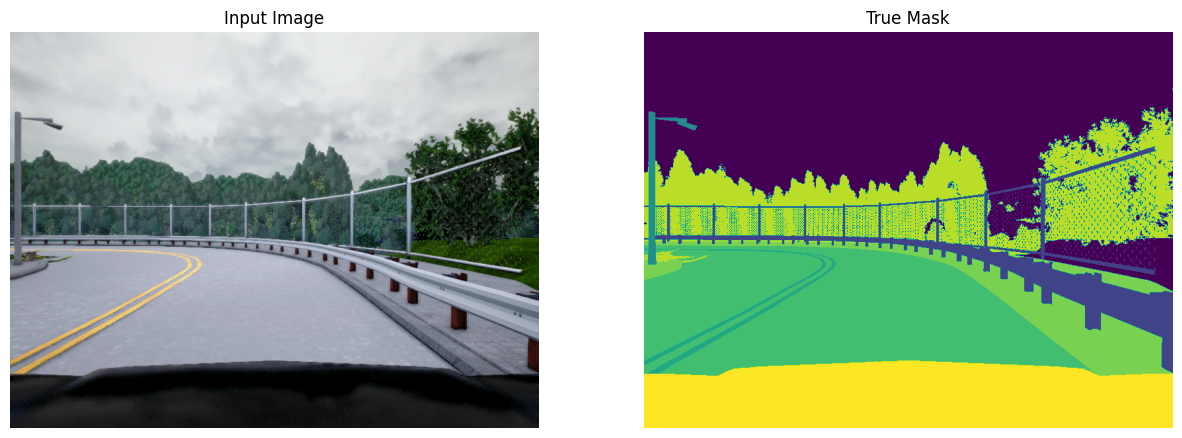

In [49]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

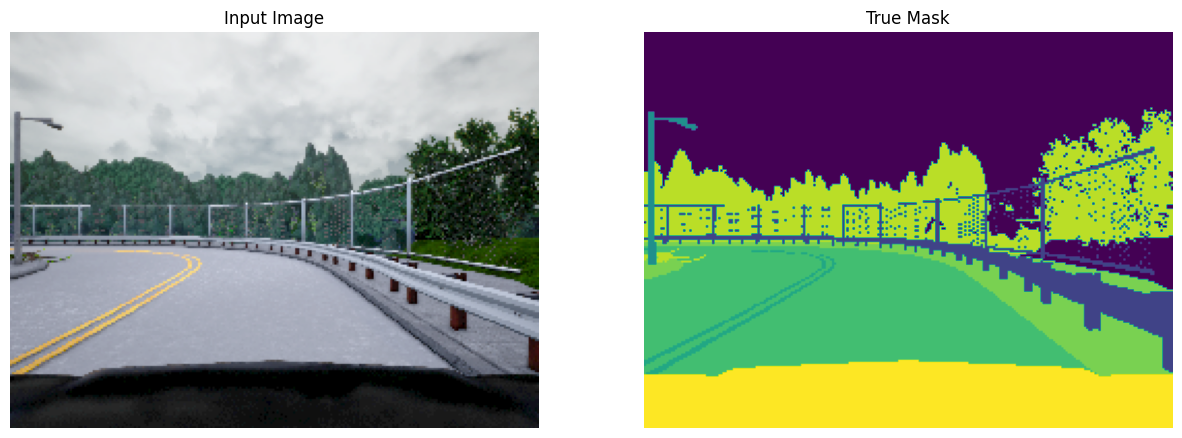

In [50]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Training models

In [51]:
EPOCHS = 50
BUFFER_SIZE = 1000
BATCH_SIZE = 64
map_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.8 * num_samples))
print(processed_image_ds)
# ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=1, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>


In [52]:
model_history1 = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.3655 - loss: 1.8586 - val_accuracy: 0.6870 - val_loss: 1.0125 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7337 - loss: 0.8168 - val_accuracy: 0.8008 - val_loss: 0.6093 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8292 - loss: 0.5302 - val_accuracy: 0.8818 - val_loss: 0.3852 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8917 - loss: 0.3493 - val_accuracy: 0.9131 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9144 - loss: 0.2719 - val_accuracy: 0.9269 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9320 - loss: 0.2133 - val_accuracy: 0.9402 - val_loss: 0.1870 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9416 - loss: 0.1816 - val_accuracy:

In [53]:
# model_history2 = unet2.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

In [54]:
# model_history3 = unet3.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

# Function to process the predicted mask

In [55]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Model's Performance

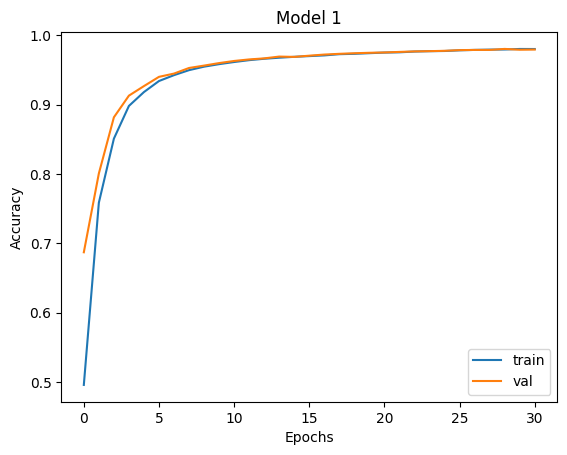

In [56]:
plt.plot(model_history1.history["accuracy"])
plt.plot(model_history1.history["val_accuracy"])
plt.title('Model 1')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

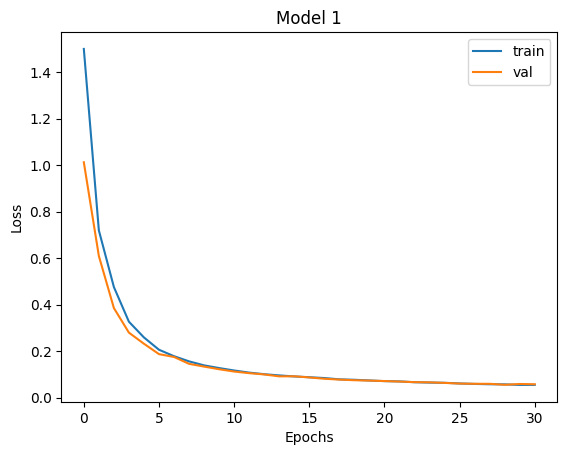

In [57]:
plt.plot(model_history1.history["loss"])
plt.plot(model_history1.history["val_loss"])
plt.title('Model 1')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [58]:
# plt.plot(model_history2.history["accuracy"])
# plt.plot(model_history2.history["val_accuracy"])
# plt.title('Model 2')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(['train', 'val'], loc='lower right')
# plt.show()

In [59]:
# plt.plot(model_history2.history["loss"])
# plt.plot(model_history2.history["val_loss"])
# plt.title('Model 2')
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()

In [60]:
# plt.plot(model_history3.history["accuracy"])
# plt.plot(model_history3.history["val_accuracy"])
# plt.title('Model 3')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(['train', 'val'], loc='lower right')
# plt.show()

In [61]:
# plt.plot(model_history3.history["loss"])
# plt.plot(model_history3.history["val_loss"])
# plt.title('Model 3')
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()

# Function to show predictions

In [62]:
def show_predictions(unet = unet, dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step


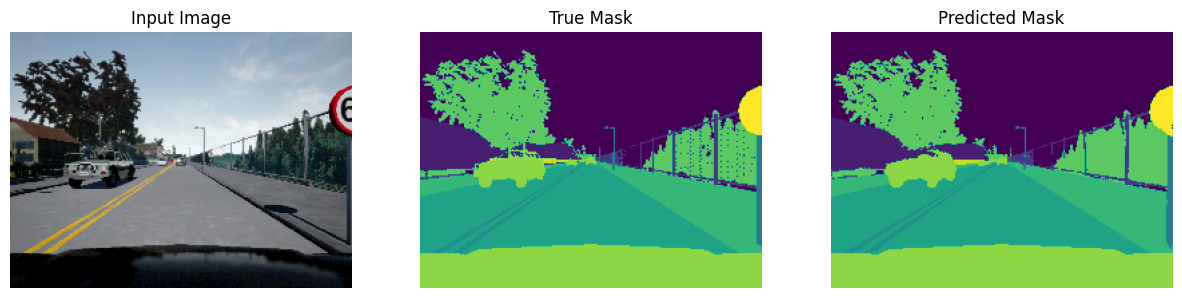

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


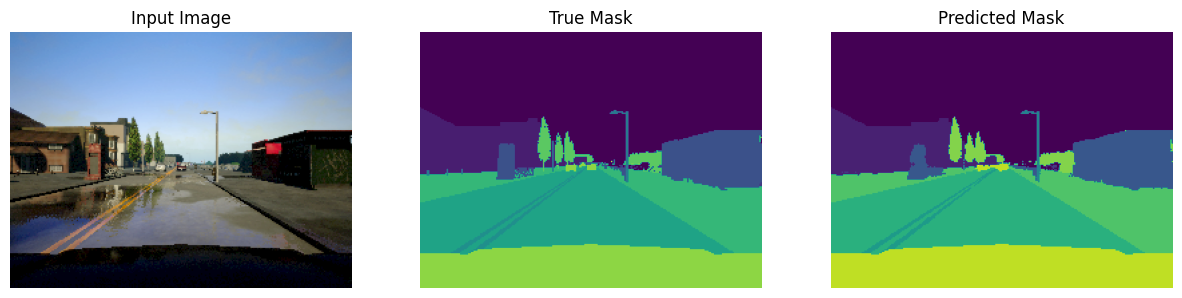

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


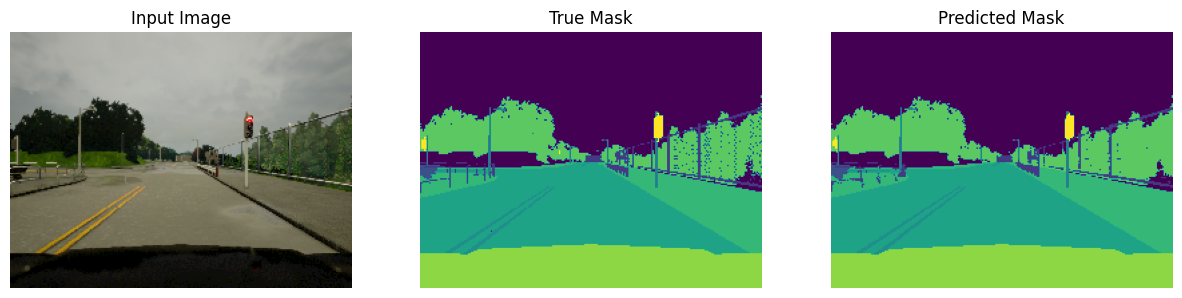

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


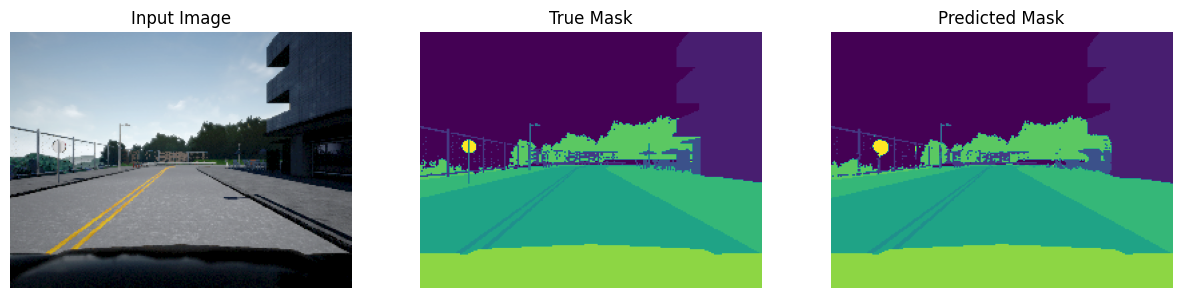

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


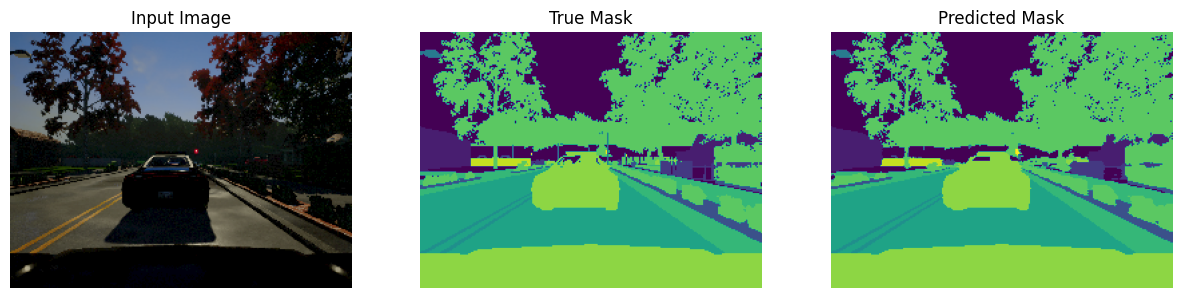

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


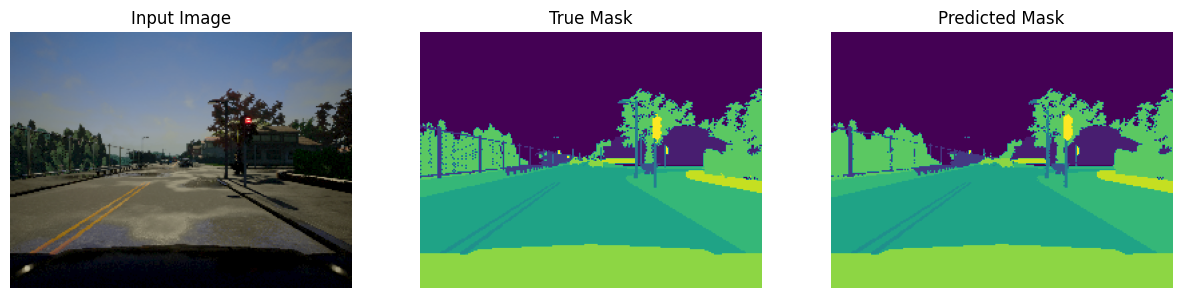

In [63]:
show_predictions(unet,train_dataset, 6)

# Saving the model

In [66]:
tf.keras.models.save_model(unet, '/kaggle/working/unet.pth')

In [65]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/model.h5', compile=False)  # Load without compiling
model.save("fixed_model.h5", include_optimizer=False)  # Save without optimizer

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Download the model

In [ ]:
# import zipfile
# import os
# from IPython.display import FileLink

# def zip_dir(directory = os.curdir, file_name = 'model.zip'):
#     """
#     zip all the files in a directory

#     Parameters
#     _____
#     directory: str
#         directory needs to be zipped, defualt is current working directory

#     file_name: str
#         the name of the zipped file (including .zip), default is 'directory.zip'

#     Returns
#     _____
#     Creates a hyperlink, which can be used to download the zip file)
#     """
#     os.chdir(directory)
#     zip_ref = zipfile.ZipFile(file_name, mode='w')
#     for folder, _, files in os.walk(directory):
#         for file in files:
#             if file_name in file:
#                 pass
#             else:
#                 zip_ref.write(os.path.join(folder, file))

#     return FileLink(file_name)

In [ ]:
# zip_dir()